<a href="https://colab.research.google.com/github/amanjain252002/Stock-Price-Prediction/blob/main/ARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
!pip install pmdarima

In [87]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings

warnings.filterwarnings('ignore')

In [88]:
StckData = pd.read_csv('Data/APPLE.csv')

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series and help us understand if the series is stationary.

**Null Hypothesis**: The series has a unit root

**Alternate Hypothesis**: The series has no unit root.

If we fail to reject the Null Hypothesis, then the series is non-stationary.

In [89]:
def Test_Stationarity(timeseries):
    result = adfuller(timeseries['Adj Close'], autolag='AIC')
    print("Results of Dickey Fuller Test")
    print(f'Test Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Number of lags used: {result[2]}')
    print(f'Number of observations used: {result[3]}')
    for key, value in result[4].items():
        print(f'critical value ({key}): {value}')

#Tesla

In [90]:
StckData.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.85,27.86,26.84,27.33,24.86,212818400.0
1,2015-01-05,27.07,27.16,26.35,26.56,24.16,257142000.0
2,2015-01-06,26.64,26.86,26.16,26.57,24.16,263188400.0
3,2015-01-07,26.80,27.05,26.67,26.94,24.50,160423600.0
4,2015-01-08,27.31,28.04,27.17,27.97,25.44,237458000.0


In [91]:
StckData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1549 non-null   object 
 1   Open       1549 non-null   float64
 2   High       1549 non-null   float64
 3   Low        1549 non-null   float64
 4   Close      1549 non-null   float64
 5   Adj Close  1549 non-null   float64
 6   Volume     1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [92]:
# Change Dtype of Date column
StckData["Date"] = pd.to_datetime(StckData["Date"])

In [93]:
Test_Stationarity(StckData)

Results of Dickey Fuller Test
Test Statistics: 1.1207222064433562
p-value: 0.9953896550774386
Number of lags used: 24
Number of observations used: 1524
critical value (1%): -3.4346481290263013
critical value (5%): -2.8634383565975736
critical value (10%): -2.567780658251872


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj Close' column to reduce the magnitude of the values and reduce the series rising trend.

In [94]:
StckData['log Adj Close'] = np.log(StckData['Adj Close'])
StckData_log_moving_avg = StckData['log Adj Close'].rolling(12).mean()
StckData_log_std = StckData['log Adj Close'].rolling(12).std()

plt.figure(figsize=(10, 5))
plt.plot(StckData['Date'], StckData_log_moving_avg, label="Rolling Mean")
plt.plot(StckData['Date'], StckData_log_std, label="Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj Close')
plt.legend(loc='best')
plt.title("Rolling Mean and Standard Deviation")

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

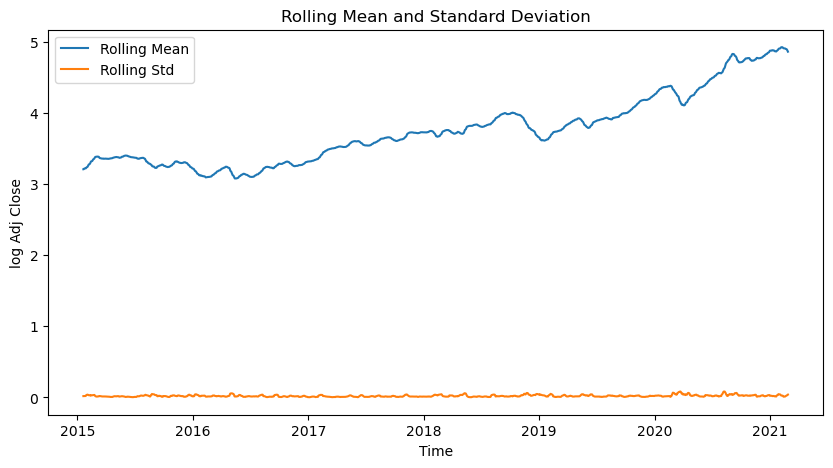

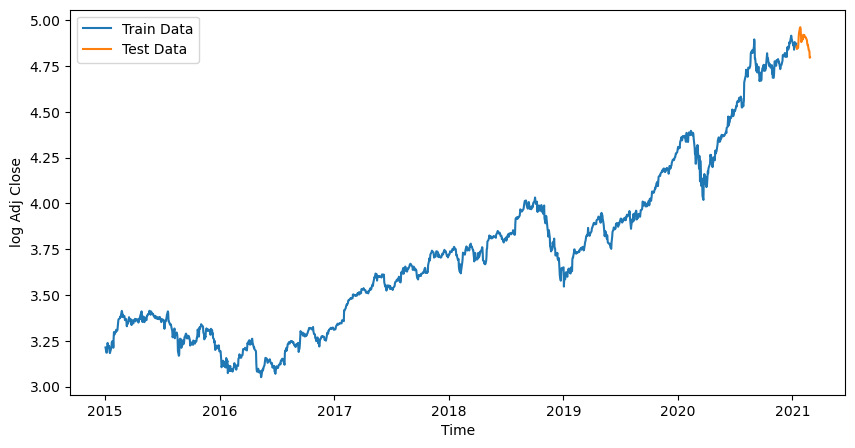

In [95]:
StckData_Train_Data = StckData[StckData['Date'] < '2021-01-14']
StckData_Test_Data = StckData[StckData['Date'] >= '2021-01-14'].reset_index(drop=True)

plt.figure(figsize=(10, 5))
plt.plot(StckData_Train_Data['Date'], StckData_Train_Data['log Adj Close'], label='Train Data')
plt.plot(StckData_Test_Data['Date'], StckData_Test_Data['log Adj Close'], label='Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj Close')
plt.legend(loc='best')
plt.show()

###Modeling

In [96]:
StckData_Auto_ARIMA_Model = auto_arima(StckData_Train_Data['log Adj Close'], seasonal=False,
                                   error_action='ignore', suppress_warnings=True)
print(StckData_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1519
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3895.536
Date:                Mon, 11 Oct 2021   AIC                          -7785.072
Time:                        12:12:53   BIC                          -7769.097
Sample:                             0   HQIC                         -7779.124
                               - 1519                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.000      2.503      0.012       0.000       0.002
ar.L1         -0.1059      0.015     -7.074      0.000      -0.135      -0.077
sigma2         0.0003   6.58e-06     52.499      0.0

In [97]:
StckData_ARIMA_Model = ARIMA(StckData_Train_Data['log Adj Close'], order=(5, 2, 2))
StckData_ARIMA_Model_Fit = StckData_ARIMA_Model.fit()
print(StckData_ARIMA_Model_Fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D2.log Adj Close   No. Observations:                 1517
Model:                 ARIMA(5, 2, 2)   Log Likelihood                3903.926
Method:                       css-mle   S.D. of innovations              0.018
Date:                Mon, 11 Oct 2021   AIC                          -7789.851
Time:                        12:12:55   BIC                          -7741.931
Sample:                             2   HQIC                         -7772.009
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.536e-06   2.39e-06      0.643      0.520   -3.15e-06    6.22e-06
ar.L1.D2.log Adj Close    -0.9548      0.044    -21.818      0.000      -1.041      -0.869
ar.L

###Predicting the closing stock price of Tesla

In [98]:
StckData_output = StckData_ARIMA_Model_Fit.forecast(30, alpha=0.05)
StckData_predictions = np.exp(StckData_output[0])
plt.figure(figsize=(10, 5))
plt.plot(StckData_Train_Data['Date'], StckData_Train_Data['Adj Close'], label='Training')
plt.plot(StckData_Test_Data['Date'], StckData_Test_Data['Adj Close'], label='Testing')
plt.plot(StckData_Test_Data['Date'], StckData_predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [99]:
rmse = math.sqrt(mean_squared_error(StckData_Test_Data['Adj Close'], StckData_predictions))
mape = np.mean(np.abs(StckData_predictions - StckData_Test_Data['Adj Close']) / np.abs(StckData_Test_Data['Adj Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')


RMSE: 8.362289155754556
MAPE: 0.04739244447753572
